## Importing the Libraries

In [1]:
# Import the Relevant Libraries
import re
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizerFast, BertForTokenClassification
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from torch.cuda.amp import GradScaler, autocast
import matplotlib.pyplot as plt

# Importing the relevant files
train_file = '../../Data/NCBItrainset_corpus.txt'
dev_file = '../../Data/NCBIdevelopset_corpus.txt'
test_file = '../../Data/NCBItestset_corpus.txt'
model_name = '../../Models/BERT_NER_model.pth'

## Data Preparation

In [2]:
# Reading the dataset file
def read_dataset(file_path):
    with open(file_path, "r") as file:
        lines = file.readlines()
    return lines

def parse_dataset(lines):
    paragraphs = []
    paragraph = []

    for line in lines:
        line = line.strip()
        if line:
            paragraph.append(line)
        else:
            if paragraph:
                paragraphs.append(paragraph)
                paragraph = []

    if paragraph:
        paragraphs.append(paragraph)

    return paragraphs

def parse_paragraph(paragraph):
    sentences = []
    annotations = []
    sentence = []

    for line in paragraph:
        if re.match(r'^\d+\|\w\|', line):
            sentence.extend(line.split('|')[2].split())

        elif re.match(r'^\d+\t\d+\t\d+\t', line):
            start, end = int(line.split("\t")[1]), int(line.split("\t")[2])
            annotations.append((start, end, line.split("\t")[3], line.split("\t")[4]))

    if sentence:
        sentences.append(sentence)
    return sentences, annotations

In [3]:
# Data Labelling
def tag_annotations(sentences, annotations):
    tagged_sentences = []
    char_count = 0

    for sentence in sentences:
        tags = ['O'] * len(sentence)    # Initialize all tags at "O"
        word_starts = []
        word_ends = []
        char_pos = 0

        for word in sentence:
            word_starts.append(char_pos)
            char_pos += len(word)
            word_ends.append(char_pos)
            char_pos += 1               # WhiteSpace Character

        '''
        Based on the character limits, the annotations are assigned
        A custom IO tagging scheme is used
        Labels are assigned on the basis of disease label in annotations
        '''

        for start, end, disease_info, label in annotations:
            for i, (word_start, word_end) in enumerate(zip(word_starts, word_ends)):
                if word_start >= start and word_end <= end:
                    tags[i] = 'I-' + label
                elif word_start < start < word_end or word_start < end < word_end:
                    tags[i] = 'I-' + label

        tagged_sentences.append((sentence, tags))

    return tagged_sentences

### Parsing the Data files

In [4]:
# Parsing the dataset file
lines = read_dataset(train_file)
paragraphs = parse_dataset(lines)

all_sentences = []
all_tags = []

for paragraph in paragraphs:
    sentences, annotations = parse_paragraph(paragraph)
    tagged_sentences = tag_annotations(sentences, annotations)
    for sentence, tags in tagged_sentences:
        all_sentences.append(sentence)
        all_tags.append(tags)

# Parsing the validation dataset file
dev_lines = read_dataset(dev_file)
dev_paragraphs = parse_dataset(dev_lines)

dev_all_sentences = []
dev_all_tags = []

for dev_paragraph in dev_paragraphs:
    dev_sentences, dev_annotations = parse_paragraph(dev_paragraph)
    dev_tagged_sentences = tag_annotations(dev_sentences, dev_annotations)
    for dev_sentence, dev_tags in dev_tagged_sentences:
        dev_all_sentences.append(dev_sentence)
        dev_all_tags.append(dev_tags)

In [5]:
# Load pre-trained BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-cased')

## Defining the Dataset Class

In [6]:
# Define Dataset class
class NERDataset(Dataset):
    def __init__(self, sentences, tags, tokenizer, tag_encoder):
        self.sentences = sentences
        self.tags = tags
        self.tokenizer = tokenizer
        self.tag_encoder = tag_encoder

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        sentence = self.sentences[idx]
        tags = self.tags[idx]

        encoding = self.tokenizer(sentence, is_split_into_words=True, return_offsets_mapping=True, padding='max_length', truncation=True, return_tensors="pt")
        labels = [-100] * len(encoding['input_ids'][0])

        word_ids = encoding.word_ids()
        for i, word_idx in enumerate(word_ids):
            if word_idx is None:
                labels[i] = -100
            else:
                labels[i] = self.tag_encoder.transform([tags[word_idx]])[0]

        return encoding['input_ids'].squeeze(), encoding['attention_mask'].squeeze(), torch.tensor(labels)

In [7]:
# Prepare data
all_tags_flat = [tag for tags in all_tags for tag in tags]

tag_encoder = LabelEncoder()
tag_encoder.fit(all_tags_flat)

LabelEncoder()

### Adadptive Class Weights

In [8]:
# Calculate class weights
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
classes = tag_encoder.classes_
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=all_tags_flat)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

dataset = NERDataset(all_sentences, all_tags, tokenizer, tag_encoder)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

cuda


## Defining the Model and it's characteristics

In [9]:
# Define BERT-based NER Model with weighted loss
class BertNERModel(nn.Module):
    def __init__(self, model_name, num_labels, class_weights):
        super(BertNERModel, self).__init__()
        self.bert = BertForTokenClassification.from_pretrained(model_name, num_labels=num_labels)
        self.dropout = nn.Dropout(0.3)  # Add dropout layer
        self.class_weights = class_weights

    def forward(self, input_ids, attention_mask, labels=None):
        output = self.bert(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        logits = self.dropout(output.logits)  # Apply dropout
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss(weight=self.class_weights, ignore_index=-100)
            loss = loss_fct(logits.view(-1, self.bert.config.num_labels), labels.view(-1))
            return loss, logits
        return logits

In [10]:
# Defining the model characteristics
model = BertNERModel('bert-base-uncased', len(tag_encoder.classes_), class_weights).to(device)
optimizer = optim.AdamW(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)
scaler = GradScaler()

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\Adit\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


## Training the Model

In [11]:
# Training using PyTorch, AdamW Optimizer, CrossEntropyLoss function and "CUDA"
model.train()
loss_dic = {}
loss_dic_comp = {}

num_epochs = 10

for epoch in range(num_epochs):
    total_loss = 0
    total_valid_loss = 0

    print(f"Starting Epoch {epoch + 1}")
    for batch_idx, batch in enumerate(dataloader):
        input_ids, attention_mask, labels = [x.to(device) for x in batch]

        optimizer.zero_grad()
        loss, outputs = model(input_ids, attention_mask, labels)
        # loss.backward()
        optimizer.step()

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        total_loss += loss.item()
        print(f"Batch ID: {batch_idx}, Loss: {loss.item()}")
        loss_dic[batch_idx] = loss.item()

    loss_dic_comp[epoch] = loss_dic
    avg_loss = total_loss / len(dataloader)
    scheduler.step(avg_loss)  # Adjust learning rate based on average loss
    print(f"Epoch: {epoch + 1}, Loss: {avg_loss}")
print("Finished Training")

Starting Epoch 1


c:\Users\Adit\anaconda3\Lib\site-packages\transformers\models\bert\modeling_bert.py:435: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

In [ ]:
def graph_plot(title, loss_dic, x_label, y_label, linestyle = '-'):
    x_data = []
    y_data = []
    x = []
    y = []
    epo = []
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    for ep, ba_info in loss_dic.items():
        epo.append(ep)
        for ba_id in ba_info:
            y.append(ba_id.values())
            x.append(ba_id.keys())
            x_data.extend(x)
            y_data.extend(y)
        x, y = [], []

    print (x_data)
    print (y_data)
    for epoch in epo:
        plt.plot(x_data, y_data, linestyle)
        plt.legend()
    plt.savefig("../../Graphs/BERT_CRF_Training.png", bbox_inches = 'tight')

[]
[]


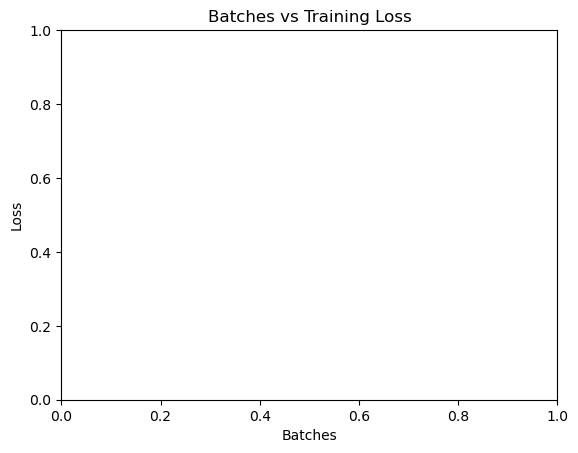

In [ ]:
graph_plot("Batches vs Training Loss", loss_dic, "Batches", "Loss")

In [ ]:
# Saving the model
torch.save(model.state_dict(), model_name)

## Testing the Model